This used latent space of 1024 and hidden of only 512. But it seems to really struggle because of the smaller hidden space.
    

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from vae import VAE5, loss_function
from helpers.summarize import TorchSummarizeDf
from helpers.dataset import NumpyDataset, TQDMDaskProgressBar, load_npzs
from helpers.samplers import SequenceInChunkSampler
from rnn import MDNRNN

# Init

In [4]:
cuda= torch.cuda.is_available()
env_name='sonic256'
num_epochs=200
batch_size = 3



# RNN
action_dim = 12
seq_len = 6
image_size=256
chunksize=seq_len*200

# VAE loss function
gamma = 0.25
C = 0

data_cache_file = '/data/tmp/sonic_rnn_256.hdf5'

# Load Data

In [5]:
# load as dask array
filenames = sorted(glob.glob('/data/vae/obs_data_' + env_name + '_*.npz'))
filenames_actions = sorted(glob.glob('/data/vae/action_data_' + env_name + '_*.npz'))
assert len(filenames)==len(filenames_actions)

if not os.path.isfile(data_cache_file):
    data_train = load_npzs(filenames, shuffle=False)
    print(data_train)
    with TQDMDaskProgressBar():
        da.to_hdf5(data_cache_file, '/x', data_train)
       
    # clear mem
    del data_train 
    import gc
    gc.collect()
    
    y_train = load_npzs(filenames_actions, shuffle=False)
    print(y_train)
    with TQDMDaskProgressBar():
        da.to_hdf5(data_cache_file, '/y', y_train)
       
    # clear mem
    del y_train 
    import gc
    gc.collect()

In [6]:
# load
data = da.from_array(h5py.File(data_cache_file, mode='r')['x'], chunks=(chunksize, image_size, image_size, 3))
actions = da.from_array(h5py.File(data_cache_file, mode='r')['y'], chunks=(chunksize, action_dim))
data
data_split = int(len(data)*0.8)
data_train = data[:data_split]
data_test = data[data_split:]
actions_train = actions[:data_split]
actions_test = actions[data_split:]
data_train.shape, actions_train.shape, data_test.shape, actions_test.shape

((232800, 256, 256, 3), (232800, 12), (58200, 256, 256, 3), (58200, 12))

In [7]:

dataset_train = NumpyDataset(data_train, actions_train)
loader_train = torch.utils.data.DataLoader(
    dataset_train, 
    sampler=SequenceInChunkSampler(dataset_train, seq_len=seq_len, chunksize=chunksize),
    pin_memory=True, 
    shuffle=False, 
    batch_size=batch_size*seq_len, 
    drop_last=True
)


dataset_test = NumpyDataset(data_test, actions_test)
loader_test = torch.utils.data.DataLoader(
    dataset_test, 
    sampler=SequenceInChunkSampler(dataset_test, seq_len=seq_len, chunksize=chunksize),
    pin_memory=True, 
    shuffle=False, 
    batch_size=batch_size*seq_len, 
    drop_last=True
)

dataset_train, loader_train

(<helpers.dataset.NumpyDataset at 0x7f43199d2da0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f43199d2e80>)

# Load VAE

In [8]:
# Load VAE
vae = VAE5(image_size=image_size, z_dim=128, conv_dim=64, code_dim=8, k_dim=512)
if cuda:
    vae.cuda()
    
# # Resume
NAME='VAE5_256im_512z'
# NAME='VAE5_3bigx256_1024z_CVAE_v2'
checkpoint_file = './models/VAE5_5bigx256_512z_CVAE_state_dict.pkl'
if os.path.isfile(checkpoint_file):
    state_dict = torch.load(checkpoint_file)
    vae.load_state_dict(state_dict)
    print(f'loaded checkpoint_file {checkpoint_file}')
    
save_file = f'./models/{NAME}-joint-training_state_dict.pkl'
if os.path.isfile(save_file):
    state_dict = torch.load(save_file)
    vae.load_state_dict(state_dict)
    print(f'loaded save_file {save_file}')

loaded checkpoint_file ./models/VAE5_5bigx256_512z_CVAE_state_dict.pkl


In [9]:
img = np.random.randn(image_size, image_size, 3)
gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float()
if cuda:
    gpu_img = gpu_img.cuda()
with TorchSummarizeDf(vae) as tdf:
    x, mu, logvar = vae.forward(gpu_img)
    print(x.size())
    print(loss_function(x, gpu_img, mu, logvar))
    x = x.data.cpu().numpy()[0].transpose(1, 2, 0)
    df = tdf.make_df()
del img, gpu_img, x, mu, logvar
df[df.level<2]

# Train

In [10]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction + KL divergence losses summed over all elements and batch
    # https://github.com/pytorch/examples/blob/master/vae/main.py
    n, c, h, w = recon_x.size()
    
    recon_x = recon_x.view(n, -1)
    x = x.view(n, -1)
    
    # L2 distance
    loss_recon = torch.sum(torch.pow(recon_x - x, 2), 1)
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1)
    return loss_recon, loss_KLD

In [11]:
# Plot reconstructions
def plot_results(loader, n=2, epoch=0, figsize=(9,6)):
    vae.eval()
    mdnrnn.eval()
    
    observations, actions = next(iter(loader))
    
    X = Variable(observations.transpose(1,3))
    _, channels, height, width = X.size()
    if cuda:
        X=X.cuda()
    Y, mu_vae, logvar = vae.forward(X)
#     loss_vae = loss_function(Y, X, mu_vae, logvar)
    loss_recon, loss_KLD = loss_function(Y, X, mu_vae, logvar)
    loss_vae = loss_recon + gamma * torch.abs(loss_KLD-C)
    
    # TODO do we want to sample in test or training mode?
    z_v = vae.sample(mu_vae, logvar)
    
    z_v = z_v.view(batch_size, seq_len, -1)
    Y = Y.view((batch_size, seq_len, channels, height, width))
    X = X.view((batch_size, seq_len, channels, height, width))
    loss_vae = loss_vae.view(batch_size, seq_len, -1)
    actions = actions.view(batch_size, seq_len, -1)
    
    # Forward
    actions_v = Variable(actions).float()
    

    if cuda:
        z_v=z_v.cuda()
        actions_v=actions_v.cuda()
    pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

    loss = mdnrnn.rnn_loss(z_v, pi, mu, sigma)
    
    # TODO tidy the following few lines
#     seq_len2 = mu.size(1)
    mu = mu.mean(2).view((batch_size*seq_len, mdnrnn.z_dim))
    X_pred = vae.decode(mu)
    X_pred = X_pred.view((batch_size, seq_len, channels, height, width))
    
    
    for i in np.linspace(0,seq_len-2,n):
        batch = np.random.randint(0,batch_size)
        i=int(i)
        y=Y[batch][i].cpu().data.transpose(0,2).numpy()
        x_orig = X[batch][i].transpose(0,2).data.cpu().numpy()
        x_next = X[batch][i+1].transpose(0,2).data.cpu().numpy()
        x_pred = X_pred[batch][i].transpose(0,2).data.cpu().numpy()
        loss_vae_i = loss_vae[batch][i].cpu().data.item()
        loss_i = loss[batch].cpu().data.item()
        
        plt.figure(figsize=figsize)
        
        plt.subplot(2, 3, 1)
        plt.axis("off")
        plt.title('original')
        plt.imshow(x_orig)

        plt.subplot(2, 3, 4)
        plt.axis("off")
        plt.imshow(y)
        plt.title('reconstructed')
           
        plt.subplot(2, 3, 2)
        plt.axis("off")
        plt.imshow(x_next)
        plt.title('true next')
        
        plt.subplot(2, 3, 5)
        plt.axis("off")
        plt.imshow(x_pred)
        plt.title('pred next')
        
        plt.subplot(2, 3, 3)
        plt.axis("off")
        plt.imshow(np.abs(x_orig-x_next))
        plt.title('actual changes')
        
        plt.subplot(2, 3, 6)
        plt.axis("off")
        plt.imshow(np.abs(y[i]-x_pred))
        plt.title('predicted changes')

        plt.suptitle('epoch {}, seq index {}, batch={}. vae_loss {:2.4f}, loss {:2.4f}'.format(
            epoch, 
            i,
            batch,
            loss_vae_i, 
            loss_i
        ))
#         plt.subplots_adjust(wspace=-.4, hspace=.1)#, bottom=0.1, right=0.8, top=0.9)
        plt.show()
        


In [12]:
import collections

def train(loader, vae, mdnrnn, optimizer, max_batches=None, test=False, cuda=True, joint_training=False):
    vae.eval()
    if test:
        mdnrnn.eval()
    else:
        mdnrnn.train()
    info = collections.defaultdict(list)
    hidden_state = None
    if max_batches is None:
        max_batches = len(loader)
    else:
        max_batches = min(max_batches, len(loader))
    iterator = iter(loader)

    with tqdm(total=max_batches*loader.batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
        for i in range(max_batches):
            # the loader batch_size is seq_len*batch_size
            # we put it through the VAE as (seq_len*batch_size,...)
            # then reshape to (batch_size,seq_len,...) for the mdnrnn
            observations, actions = next(iterator)
            X = Variable(observations.transpose(1,3))
            if cuda:
                X=X.cuda()
                
            # VAE forward
            Y, mu_vae, logvar = vae.forward(X)
            # TODO do we want to sample in test or training mode?
            z_v = vae.sample(mu_vae, logvar)
            z_v = z_v.view(batch_size, seq_len, -1)
            
#             loss_vae = loss_function(Y, X, mu_vae, logvar).mean()
            loss_recon, loss_KLD = loss_function(Y, X, mu_vae, logvar)
            loss_vae = loss_recon + gamma * torch.abs(loss_KLD-C)
            loss_vae = loss_vae.mean() # mean along the batches
            
            info['loss_vae'].append(loss_vae.cpu().data.numpy())
            info['loss_recon'].append(loss_recon.mean().cpu().data.item())
            info['loss_KLD'].append(loss_KLD.mean().cpu().data.item())
            
            if joint_training:
                # TODO what's the best way to do joint training
                if not test:
                    loss_vae.backward(retain_graph=True)
                    optimizer_vae.step()
                    optimizer_vae.zero_grad()
            else:
                z_v = z_v.detach()

            # MDNRNN Forward
            actions_v = Variable(actions).float()
            actions_v = actions_v.view(batch_size, seq_len, -1)
            if cuda:
                z_v=z_v.cuda()
                actions_v=actions_v.cuda()
            pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

            loss_mdn = mdnrnn.rnn_loss(z_v, pi, mu, sigma).mean()
            info['loss_mdn'].append(loss_mdn.cpu().data.numpy())

            if not test:
                loss_mdn.backward()
                optimizer.step()
                optimizer_vae.step()
                optimizer.zero_grad()

            prog.update(loader.batch_size)
            prog.desc='loss_rnn={loss_mdn:2.4f}, loss_vae={loss_recon:2.2f} + {gamma}*|{loss_KLD:2.2f} - {C}|'.format(
                loss_mdn=np.mean(info['loss_mdn']), 
                loss_recon=np.mean(info['loss_recon']),
                gamma=gamma,
                C=C,
                loss_KLD=np.mean(info['loss_KLD']),
            )

        print(prog.desc)
        prog.close()

    return info

## Init

In [13]:
# Load MDRNN
z_dim, action_dim, hidden_size, n_mixture, temp = 512, 12, 512, 3, 0.0


mdnrnn = MDNRNN(z_dim, action_dim, hidden_size, n_mixture, temp)

if cuda:
    mdnrnn = mdnrnn.cuda()

import torch.optim.lr_scheduler
optimizer = optim.Adam(mdnrnn.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

optimizer_vae = optim.Adam(vae.parameters(), lr=3e-5)
scheduler_vae = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vae, mode='min', patience=3, verbose=True)

In [14]:
# # Resume?
NAME='RNN_v3b_256im_512z'
save_file = f'./models/{NAME}_state_dict.pkl'
if os.path.isfile(save_file):
    state_dict = torch.load(f'./models/{NAME}_state_dict.pkl')
    mdnrnn.load_state_dict(state_dict)
    print(f'loaded {save_file}')

In [15]:
img = np.random.randn(image_size, image_size, 3)
action = Variable(torch.from_numpy(np.random.randint(0,12,(12)))).float().cuda()[np.newaxis]
gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float().cuda()
if cuda:
    gpu_img = gpu_img.cuda()
with TorchSummarizeDf(mdnrnn) as tdf:
    x, mu, logvar = vae.forward(gpu_img)
    z = vae.sample(mu, logvar)
    mdnrnn.forward(z.unsqueeze(1).repeat((1,2,1)), action.unsqueeze(1).repeat((1,2,1)))
    print(x.size())
    print(loss_function(x, gpu_img, mu, logvar))
    x = x.data.cpu().numpy()[0].transpose(1, 2, 0)
    df = tdf.make_df()
    
del img, action, gpu_img, x, mu, z
df[df.level<3]

## Train

In [16]:
max_batches=40000//loader_train.batch_size
max_batches
torch.cuda.empty_cache()

In [17]:
# Load previous history
import pandas as pd
if os.path.isfile(f'./models/{NAME}.csv'):
    histories = pd.read_csv(f'./models/{NAME}.csv').to_dict(orient='records')
else:
    histories = []

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


loss_rnn=0.8179, loss_vae=2576.39 + 0.25*|132.73 - 0|



loss_rnn=0.5372, loss_vae=2286.53 + 0.25*|110.13 - 0|

Epoch 0, loss=0.8179, loss_val=0.5372 loss_vae=2609.5679 loss_vae_val=2314.0588


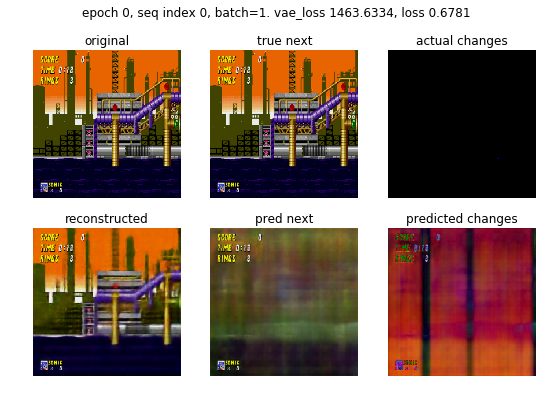

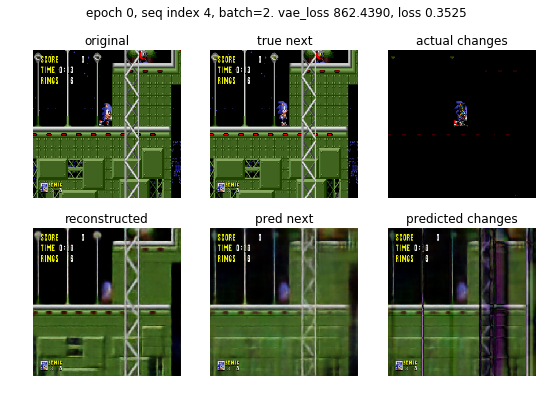

loss_rnn=0.3647, loss_vae=2558.98 + 0.25*|106.95 - 0|



loss_rnn=-0.3242, loss_vae=817.01 + 0.25*|70.74 - 0|

Epoch 1, loss=0.3647, loss_val=-0.3242 loss_vae=2585.7166 loss_vae_val=834.6912


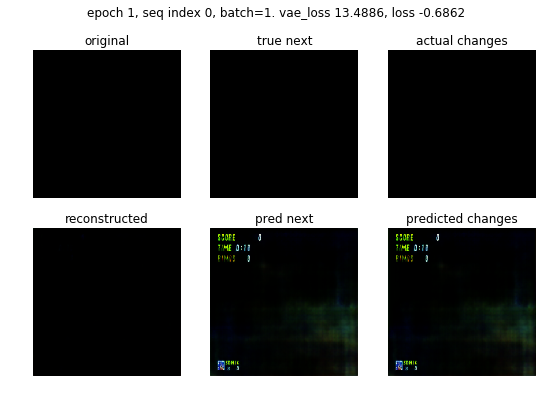

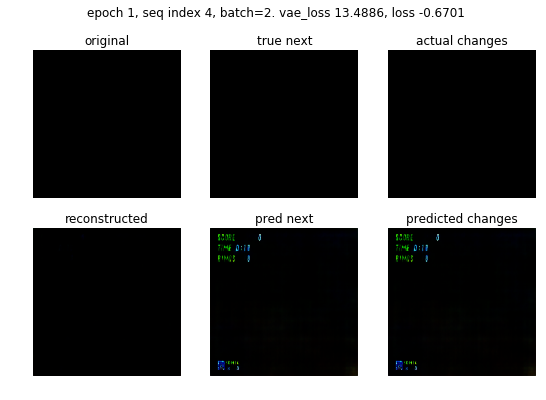

loss_rnn=0.1122, loss_vae=2466.90 + 0.25*|98.87 - 0|



loss_rnn=-0.2585, loss_vae=1598.65 + 0.25*|78.88 - 0|

Epoch 2, loss=0.1122, loss_val=-0.2585 loss_vae=2491.6172 loss_vae_val=1618.3672


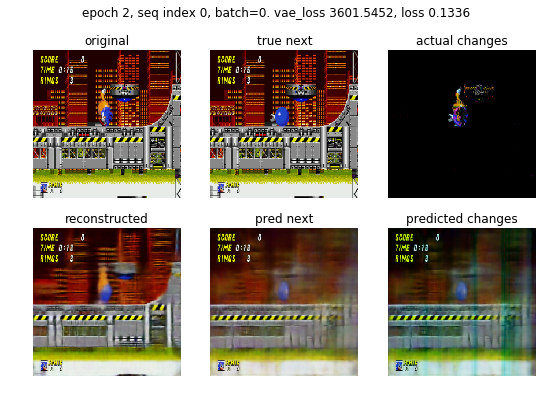

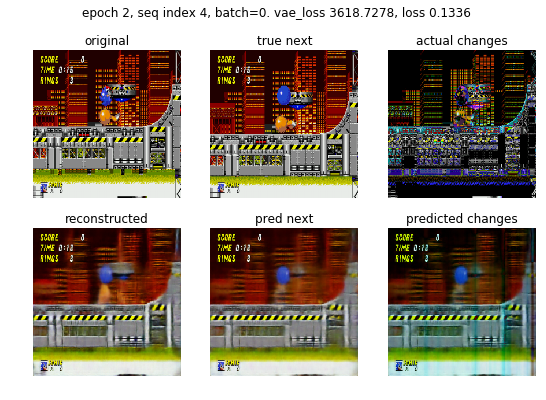

loss_rnn=-0.1342, loss_vae=2409.17 + 0.25*|94.82 - 0|



loss_rnn=-0.3243, loss_vae=2014.76 + 0.25*|75.51 - 0|

Epoch 3, loss=-0.1342, loss_val=-0.3243 loss_vae=2432.8779 loss_vae_val=2033.6436


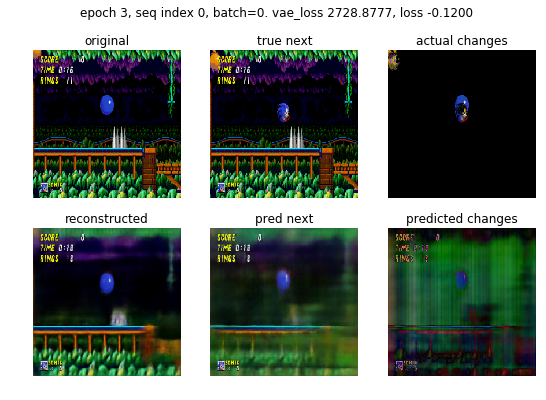

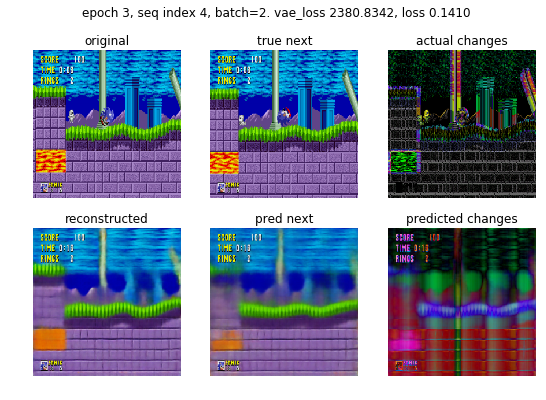

loss_rnn=-0.3573, loss_vae=2422.29 + 0.25*|88.61 - 0|



loss_rnn=-0.1872, loss_vae=2255.72 + 0.25*|80.58 - 0|

Epoch 4, loss=-0.3573, loss_val=-0.1872 loss_vae=2444.4448 loss_vae_val=2275.8669


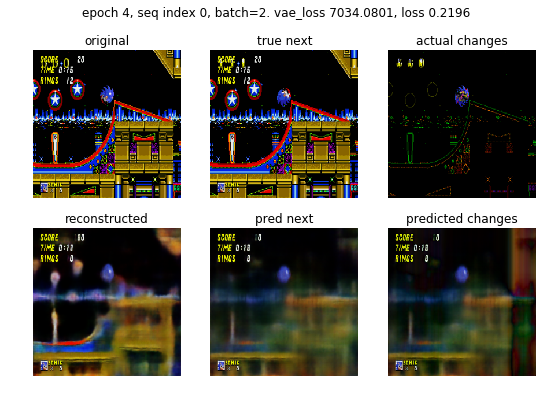

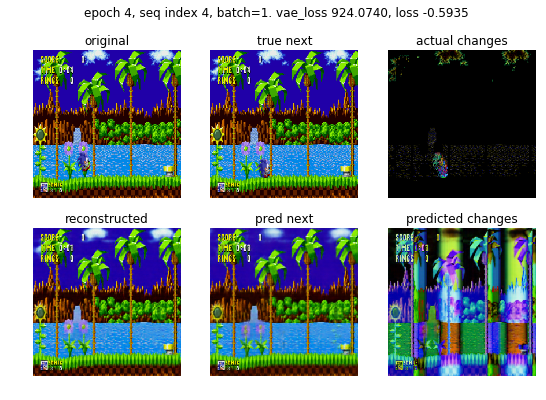

loss_rnn=-0.5370, loss_vae=2423.76 + 0.25*|83.63 - 0|



loss_rnn=-0.5808, loss_vae=1563.29 + 0.25*|67.70 - 0|

Epoch     5: reducing learning rate of group 0 to 3.0000e-06.
Epoch 5, loss=-0.5370, loss_val=-0.5808 loss_vae=2444.6682 loss_vae_val=1580.2129


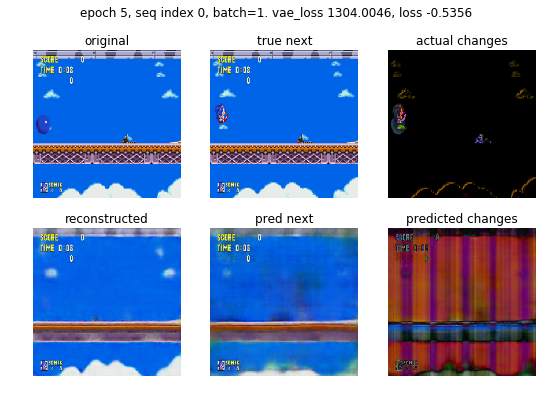

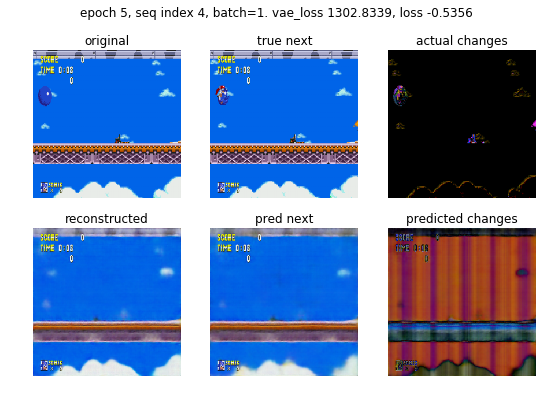

loss_rnn=-0.6219, loss_vae=2634.17 + 0.25*|82.58 - 0|



loss_rnn=-0.5253, loss_vae=2034.81 + 0.25*|72.54 - 0|

Epoch 6, loss=-0.6219, loss_val=-0.5253 loss_vae=2654.8169 loss_vae_val=2052.9436


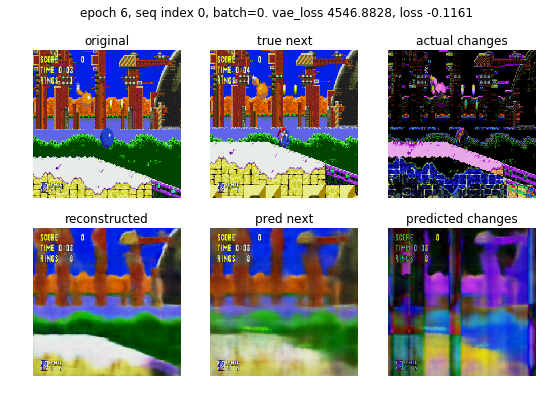

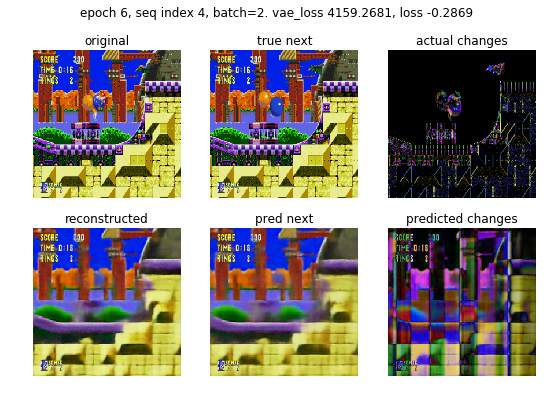

loss_rnn=-0.7853, loss_vae=2529.11 + 0.25*|80.71 - 0|



loss_rnn=-0.5300, loss_vae=1922.71 + 0.25*|73.40 - 0|

Epoch 7, loss=-0.7853, loss_val=-0.5300 loss_vae=2549.2888 loss_vae_val=1941.0547


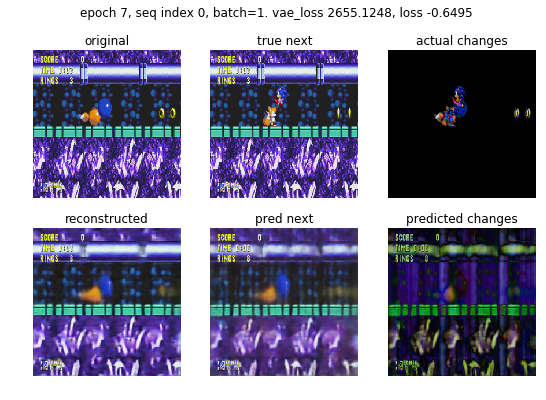

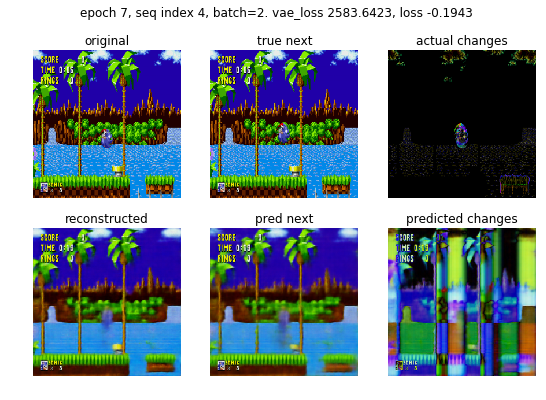

loss_rnn=-0.8662, loss_vae=2445.06 + 0.25*|82.16 - 0|



loss_rnn=-0.5161, loss_vae=2180.99 + 0.25*|77.29 - 0|

Epoch 8, loss=-0.8662, loss_val=-0.5161 loss_vae=2465.6016 loss_vae_val=2200.3137


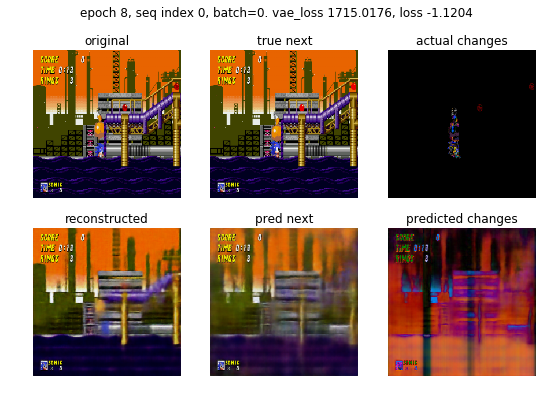

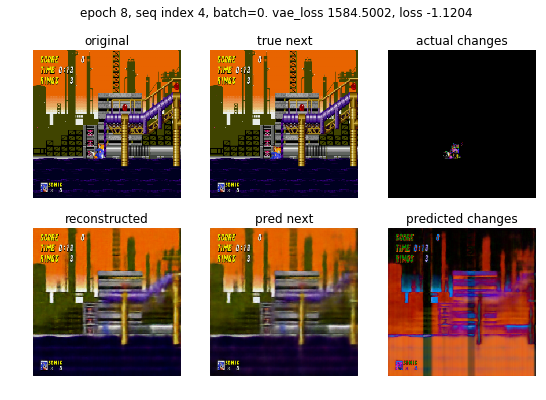

loss_rnn=-0.9709, loss_vae=2381.17 + 0.25*|79.27 - 0|



loss_rnn=-0.4470, loss_vae=2502.64 + 0.25*|82.66 - 0|

Epoch     9: reducing learning rate of group 0 to 1.0000e-05.
Epoch     9: reducing learning rate of group 0 to 3.0000e-07.
Epoch 9, loss=-0.9709, loss_val=-0.4470 loss_vae=2400.9912 loss_vae_val=2523.3096


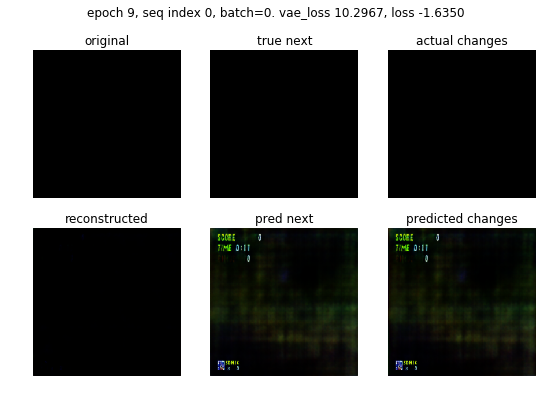

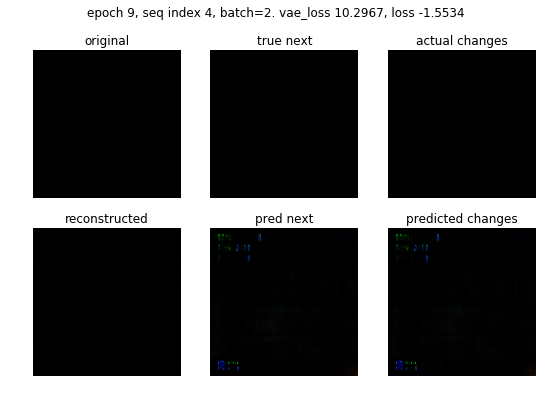

loss_rnn=-1.0066, loss_vae=2453.87 + 0.25*|81.24 - 0|



loss_rnn=-0.9432, loss_vae=1600.60 + 0.25*|65.60 - 0|

Epoch 10, loss=-1.0066, loss_val=-0.9432 loss_vae=2474.1843 loss_vae_val=1616.9955


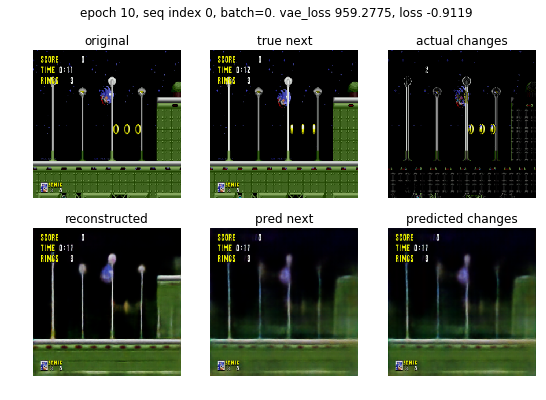

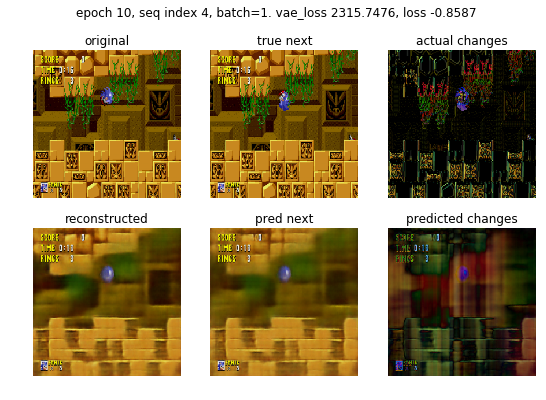

In [ ]:

for epoch in range(num_epochs):
    # Run
    info = train(loader_train, vae, mdnrnn, optimizer, max_batches=max_batches, test=False, cuda=True, joint_training=True)
    torch.cuda.empty_cache()
    info_val = train(loader_test, vae, mdnrnn, optimizer, max_batches=max_batches//6, test=True, cuda=True, joint_training=True)
    torch.cuda.empty_cache()
    
    # Adjust
    scheduler.step(np.mean(info_val['loss_mdn']))
    scheduler_vae.step(np.mean(info_val['loss_vae']))
    
    # View
    print('Epoch {}, loss={:2.4f}, loss_val={:2.4f} loss_vae={:2.4f} loss_vae_val={:2.4f}'.format(
        epoch, 
        np.mean(info['loss_mdn']), 
        np.mean(info_val['loss_mdn']),
        np.mean(info['loss_vae']), 
        np.mean(info_val['loss_vae'])
    ))
    plot_results(loader_test, n=2, epoch=epoch)
    
    # Record
    history = {k+'_val':np.mean(v) for k,v in info_val.items()}
    history.update({k:np.mean(v) for k,v in info.items()})
    histories.append(history)
    
    torch.save(mdnrnn.state_dict(), f'./models/{NAME}_{epoch}_state_dict.pkl')
    torch.save(vae.state_dict(), f'./models/{NAME}-joint-training__{epoch}_state_dict.pkl')
    
    # Tidy
    torch.cuda.empty_cache()

In [ ]:
import pandas as pd
df_history = pd.DataFrame(histories)
df_history.plot()

In [ ]:
df_history[['loss_mdn','loss_mdn_val']].plot()

## Save

In [ ]:
torch.save(mdnrnn.state_dict(), f'./models/{NAME}_state_dict.pkl')
torch.save(vae.state_dict(), f'./models/{NAME}-joint-training_state_dict.pkl')
df_history.to_csv(f'./models/{NAME}.csv', index=False)

torch.save(mdnrnn, f'./models/{NAME}.pkl')
torch.save(vae, f'./models/{NAME}-joint-training.pkl')

## View

In [ ]:
plot_results(loader_test, n=4, epoch=0)

In [ ]:
plot_results(loader_train, n=4, epoch=0)

In [ ]:
torch.cuda.empty_cache()

loss=-3.7780: 6% 1120/20000 [00:20<05:40, 55.42it/s]